# BLU06 - Learning Notebook - Data wrangling workflows - Part 2 of 3

# Imports

In [1]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn')

import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

# 2 Combining dataframes in Pandas

## 2.1 How many programs are there per season?

Your first question is, how many different programs does the NYP typically present, per season.

As explained above, programs are arranged under `/data/programs/`, which contains a number of files, one per Season.

Let's sample one of the files, for reference.

In [2]:
!head -3 ../data/programs/1842-43.csv

GUID,ProgramID,Orchestra,Season
38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,New York Philharmonic,1842-43
c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,New York Philharmonic,1842-43


### Concatenate

In order to analyze how many programs there are per season, over time, we want to create a single dataframe, containing all seasons.

Concatenation means, in short, to unite multiple dataframes (or series) in one. 

The `pd.concat()` function performs concatenation operations along an axis (`axis=0` for index and `axis=1` for columns).

In [3]:
season_0 = pd.read_csv('../data/programs/1842-43.csv')
season_1 = pd.read_csv('../data/programs/1843-44.csv')

seasons = [season_0, season_1]
pd.concat(seasons, axis=1)

,GUID,ProgramID,Orchestra,Season,GUID,ProgramID,Orchestra,Season
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,New York Philharmonic,1842-43,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,New York Philharmonic,1843-44
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,New York Philharmonic,1842-43,47b6e9e8-3b18-49ea-ae2a-b9b0ca18902c,3368,New York Philharmonic,1843-44
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,Musicians from the New York Philharmonic,1842-43,5e533e4f-d4ac-4aaa-b8d2-e189f6806655,4226,New York Philharmonic,1843-44
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,New York Philharmonic,1842-43,7550f75e-5c0c-4519-9196-05a6c4e2612c,5087,New York Philharmonic,1843-44


Concatenating like this makes no sense, as we end up violating the tidy data principle of having *a single observation per row*.

What we want to do instead is to concatenate the dataframe along the index.

In [4]:
pd.concat(seasons, axis=0)

,GUID,ProgramID,Orchestra,Season
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,New York Philharmonic,1842-43
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,New York Philharmonic,1842-43
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,Musicians from the New York Philharmonic,1842-43
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,New York Philharmonic,1842-43
0,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,New York Philharmonic,1843-44
1,47b6e9e8-3b18-49ea-ae2a-b9b0ca18902c,3368,New York Philharmonic,1843-44
2,5e533e4f-d4ac-4aaa-b8d2-e189f6806655,4226,New York Philharmonic,1843-44
3,7550f75e-5c0c-4519-9196-05a6c4e2612c,5087,New York Philharmonic,1843-44


This look better, but there's something weird with the index: it's not unique anymore and different observations share the same index.

Not cool.

In [5]:
seasons_df = pd.concat(seasons, axis=0)
seasons_df.loc[0, :]

,GUID,ProgramID,Orchestra,Season
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,New York Philharmonic,1842-43
0,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,New York Philharmonic,1843-44


What can we do to make it cleaner? A solution would be hard-core some `keys` (multi-indexing!).

In [6]:
pd.concat(seasons, axis=0, keys=['1842-43', '1843-44'])

GUID  ProgramID  \
1842-43 0  38e072a7-8fc9-4f9a-8eac-3957905c0002       3853   
        1  c7b2b95c-5e0b-431c-a340-5b37fc860b34       5178   
        2  894e1a52-1ae5-4fa7-aec0-b99997555a37      10785   
        3  34ec2c2b-3297-4716-9831-b538310462b7       5887   
1843-44 0  610a4acc-94e4-4cd6-bdc1-8ad020edc7e9        305   
        1  47b6e9e8-3b18-49ea-ae2a-b9b0ca18902c       3368   
        2  5e533e4f-d4ac-4aaa-b8d2-e189f6806655       4226   
        3  7550f75e-5c0c-4519-9196-05a6c4e2612c       5087   

                                          Orchestra   Season  
1842-43 0                     New York Philharmonic  1842-43  
        1                     New York Philharmonic  1842-43  
        2  Musicians from the New York Philharmonic  1842-43  
        3                     New York Philharmonic  1842-43  
1843-44 0                     New York Philharmonic  1843-44  
        1                     New York Philharmonic  1843-44  
        2                     New York Philharmonic  1843-44  
        3                     New York Philharmonic  1843-44

From here, you can proceed normally! Let the multi-index fun begin.

In [7]:
seasons_df_ = pd.concat(seasons, axis=0, keys=['1842-43', '1843-44'])

idx = pd.IndexSlice
seasons_df_.loc[idx['1842-43', 0], :]

GUID         38e072a7-8fc9-4f9a-8eac-3957905c0002
ProgramID                                    3853
Orchestra                   New York Philharmonic
Season                                    1842-43
Name: (1842-43, 0), dtype: object

Now, let's try something different. Let's try to change the name of the columns, so that each dataframe has different ones, before concatenating.

In [8]:
season_0_ = season_0.copy()
season_0_.columns = [0, 1, 2, 'Season']
seasons_ = [season_0_, season_1]
pd.concat(seasons_, axis=0)

,0,1,2,Season,GUID,ProgramID,Orchestra
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853.0,New York Philharmonic,1842-43,NaN,NaN,NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178.0,New York Philharmonic,1842-43,NaN,NaN,NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785.0,Musicians from the New York Philharmonic,1842-43,NaN,NaN,NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887.0,New York Philharmonic,1842-43,NaN,NaN,NaN
0,NaN,NaN,NaN,1843-44,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305.0,New York Philharmonic
1,NaN,NaN,NaN,1843-44,47b6e9e8-3b18-49ea-ae2a-b9b0ca18902c,3368.0,New York Philharmonic
2,NaN,NaN,NaN,1843-44,5e533e4f-d4ac-4aaa-b8d2-e189f6806655,4226.0,New York Philharmonic
3,NaN,NaN,NaN,1843-44,7550f75e-5c0c-4519-9196-05a6c4e2612c,5087.0,New York Philharmonic


What a mess! What did we learn?

* When the dataframes have different columns, `pd.concat()` will take the union of all dataframes by default (zero information loss)
* Columns that are not present for specific dataframes will be filled in `np.NaN` (missing values).

The good news are that you can set how you want to glue the dataframes in regards to the axis that is not being concatenated. 

Setting `join='inner'` will take the intersection, i.e., the columns that are present in all dataframes.

In [9]:
pd.concat(seasons_, axis=0, join='inner')

,Season
0,1842-43
1,1842-43
2,1842-43
3,1842-43
0,1843-44
1,1843-44
2,1843-44
3,1843-44


Back to our index problem, for dataframes that don't have a meaningful index, you may wish to ignore the indexes altogether.

In [10]:
pd.concat(seasons, axis=0, ignore_index=True)

,GUID,ProgramID,Orchestra,Season
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,New York Philharmonic,1842-43
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,New York Philharmonic,1842-43
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,Musicians from the New York Philharmonic,1842-43
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,New York Philharmonic,1842-43
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,New York Philharmonic,1843-44
5,47b6e9e8-3b18-49ea-ae2a-b9b0ca18902c,3368,New York Philharmonic,1843-44
6,5e533e4f-d4ac-4aaa-b8d2-e189f6806655,4226,New York Philharmonic,1843-44
7,7550f75e-5c0c-4519-9196-05a6c4e2612c,5087,New York Philharmonic,1843-44


There you go, concatenation complete.

### Append

The method `df.append()` is a shortcut for `pd.concat()`, that can be called on either a `pd.DataFrame` or a `pd.Series`.

In [11]:
season_0.append(season_1)

,GUID,ProgramID,Orchestra,Season
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,New York Philharmonic,1842-43
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,New York Philharmonic,1842-43
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,Musicians from the New York Philharmonic,1842-43
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,New York Philharmonic,1842-43
0,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,New York Philharmonic,1843-44
1,47b6e9e8-3b18-49ea-ae2a-b9b0ca18902c,3368,New York Philharmonic,1843-44
2,5e533e4f-d4ac-4aaa-b8d2-e189f6806655,4226,New York Philharmonic,1843-44
3,7550f75e-5c0c-4519-9196-05a6c4e2612c,5087,New York Philharmonic,1843-44


That is convenient! It can take multiple objects to concatenate as well. Please note the use of `ignore_index=True`.

In [12]:
season_2 = pd.read_csv('../data/programs/1844-45.csv')

more_seasons = [season_1, season_2]
season_0.append(more_seasons, ignore_index=True)

,GUID,ProgramID,Orchestra,Season
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,New York Philharmonic,1842-43
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,New York Philharmonic,1842-43
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,Musicians from the New York Philharmonic,1842-43
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,New York Philharmonic,1842-43
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,New York Philharmonic,1843-44
5,47b6e9e8-3b18-49ea-ae2a-b9b0ca18902c,3368,New York Philharmonic,1843-44
6,5e533e4f-d4ac-4aaa-b8d2-e189f6806655,4226,New York Philharmonic,1843-44
7,7550f75e-5c0c-4519-9196-05a6c4e2612c,5087,New York Philharmonic,1843-44
8,91f716fc-090d-4c3b-85da-41122eb3fe96,6310,New York Philharmonic,1844-45
9,253d22e1-9d44-410c-ae06-61abe434e5ec,1979,New York Philharmonic,1844-45


We are good to go. Let's use `pd.concat` to combine all seasons into a glorious dataframe.

In [13]:
def read_season(file):
    path = os.path.join('..', 'data', 'programs', file)
    return pd.read_csv(path)

files = os.listdir('../data/programs/')
files = [f for f in files if '.csv' in f]

A logical approach would be to iterate over all files and appending all of them to a single data frame.

In [14]:
%%timeit

programs = pd.DataFrame()
for file in files:
    season = read_season(file)
    programs = programs.append(season, ignore_index=True)

358 ms ± 5.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It is worth noting that both `pd.concat()` and `df.append()` make a full copy of the data:onstantly reusing this function can create a significant performance hit. 

Instead, if you need to use the operation over several times, use a list comprehension.

In [15]:
%%timeit

seasons = [read_season(f) for f in files if '.csv' in f]
programs = pd.concat(seasons, axis=0, ignore_index=True)

195 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
seasons = [read_season(f) for f in files if '.csv' in f]
programs = pd.concat(seasons, axis=0, ignore_index=True)

Now that we have the final `programs` dataframe, we can see how the number of distinct programs changes over time.

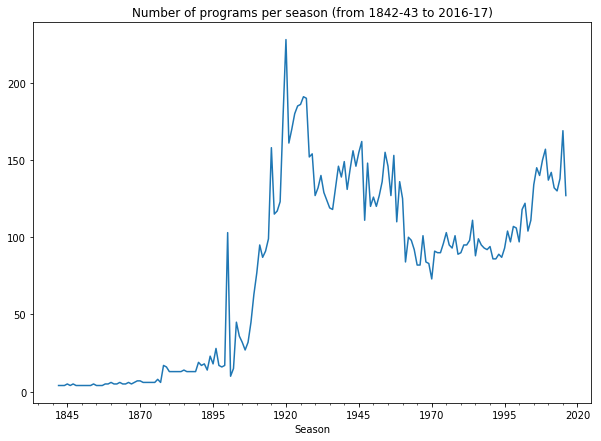

In [17]:
programs['Season'] = pd.to_datetime(programs['Season'].str[:4])

(programs.groupby('Season')
         .size()
         .plot(legend=False, use_index=True, figsize=(10, 7),
               title='Number of programs per season (from 1842-43 to 2016-17)'));

The NYP appears to be investing on increasing the number of distinct programs per season since '95. 

## 2.2 How many concerts are there per season?

What about the number of concerts? The first thing we need to do is to import the `concerts.csv` data.

In [18]:
concerts = pd.read_csv('../data/concerts.csv')
concerts.head()

,GUID,ProgramID,ConcertID,EventType,Location,Venue,Date,Time
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,0,Subscription Season,"Manhattan, NY",Apollo Rooms,1842-12-07T05:00:00+00:00,8:00PM
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,0,Subscription Season,"Manhattan, NY",Apollo Rooms,1843-02-18T05:00:00+00:00,8:00PM
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,0,Special,"Manhattan, NY",Apollo Rooms,1843-04-07T05:00:00+00:00,8:00PM
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,0,Subscription Season,"Manhattan, NY",Apollo Rooms,1843-04-22T05:00:00+00:00,8:00PM
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,0,Subscription Season,"Manhattan, NY",Apollo Rooms,1843-11-18T05:00:00+00:00,NaN


We will use the Leon Levy Digital Archives ID (`GUID`) to identify each program.

Now, we have information regarding all the concerts that took place and the season for each program.

The problem? Information about the concert and the season are in different tables, and the program is the glue between the two. Familiar?

### Merge

Pandas provides high performance join operations, very similar to SQL.

The method `df.merge()` method provides an interface for all database-like join methods.

In [19]:
?pd.merge

Signature: pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
Docstring:
Merge DataFrame objects by performing a database-style join operation by
columns or indexes.

If joining columns on columns, the DataFrame indexes *will be
ignored*. Otherwise if joining indexes on indexes or indexes on a column or
columns, the index will be passed on.

Parameters
----------
left : DataFrame
right : DataFrame
how : {'left', 'right', 'outer', 'inner'}, default 'inner'
    * left: use only keys from left frame, similar to a SQL left outer join;
      preserve key order
    * right: use only keys from right frame, similar to a SQL right outer join;
      preserve key order
    * outer: use union of keys from both frames, similar to a SQL full outer
      join; sort keys lexicographically
    * inner: use intersection of keys from both frames, similar to a SQL inner


We can call `pd.merge` to join both tables on the `GUID` (and the `ProgramID`, that provides similar info).

In [20]:
# Since GUID and ProgramID offer similar info, we will drop the later.
programs = programs.drop(columns='ProgramID')

df = pd.merge(programs, concerts, on='GUID')
df.head()

,GUID,Orchestra,Season,ProgramID,ConcertID,EventType,Location,Venue,Date,Time
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670,0,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-09T04:00:00+00:00,8:30PM
1,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670,1,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-10T04:00:00+00:00,2:30PM
2,8e4f7608-02d3-42eb-bc5a-c0784c310790,New/National Symphony Orchestra,1919-01-01,13672,0,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-23T04:00:00+00:00,8:30PM
3,8e4f7608-02d3-42eb-bc5a-c0784c310790,New/National Symphony Orchestra,1919-01-01,13672,1,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-24T04:00:00+00:00,2:30PM
4,b9f4359e-135d-4535-9a63-335b43db14d8,New York Philharmonic,1919-01-01,3884,0,Tour,"Newark, NJ",The Armory,1919-11-03T05:00:00+00:00,8:15PM


Or, alternatively, we can call `merge()` directly on the dataframe.

In [21]:
df_ = programs.merge(concerts, on='GUID')
df_.head()

,GUID,Orchestra,Season,ProgramID,ConcertID,EventType,Location,Venue,Date,Time
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670,0,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-09T04:00:00+00:00,8:30PM
1,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670,1,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-10T04:00:00+00:00,2:30PM
2,8e4f7608-02d3-42eb-bc5a-c0784c310790,New/National Symphony Orchestra,1919-01-01,13672,0,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-23T04:00:00+00:00,8:30PM
3,8e4f7608-02d3-42eb-bc5a-c0784c310790,New/National Symphony Orchestra,1919-01-01,13672,1,Subscription Season,"Manhattan, NY",Carnegie Hall,1919-10-24T04:00:00+00:00,2:30PM
4,b9f4359e-135d-4535-9a63-335b43db14d8,New York Philharmonic,1919-01-01,3884,0,Tour,"Newark, NJ",The Armory,1919-11-03T05:00:00+00:00,8:15PM


The key parameter here is the `how`. Since we are not explicitly using it, the merge default to `inner` (for inner-join) by default.

But, in fact you can use any type of join, just like you did in SQL: `left`, `right`, `outer` and `inner`.

Remember?

![](../media/types_of_joins.jpg)

*Fig. 1 - Types of joins in SQL, note how left, right, outer and inner translate directly to Pandas.*

A refresher on different types of joins, all supported by Pandas:

| Pandas                                         | SQL              | What it does                              |
| ---------------------------------------------- | ---------------- | ----------------------------------------- |
| `pd.merge(right, left, on='key', how='left')`  | LEFT OUTER JOIN  | Use all keys from left frame only         |
| `pd.merge(right, left, on='key', how='right')` | RIGHT OUTER JOIN | Use all keys from right frame only        |
| `pd.merge(right, left, on='key', how='outer')` | FULL OUTER JOIN  | Use union of keys from both frames        |
| `pd.merge(right, left, on='key', how='inner')` | INNER JOIN       | Use intersection of keys from both frames |

In this particular case, we have:
* A one-to-many relationship (i.e., one program to many concerts)
* Since every single concert in `concerts` has a match in `programs`, the type of join we use doesn't really matter.

We can use the validate argument to automatically check whether there are unexpected duplicates in their merge keys and check key uniqueness.

In [22]:
_df = pd.merge(programs, concerts, on='GUID', how='outer', validate="one_to_many")
assert(concerts.shape[0] == df_.shape[0] == _df.shape[0])

Back to our question, how is the number of concerts per season evolving?

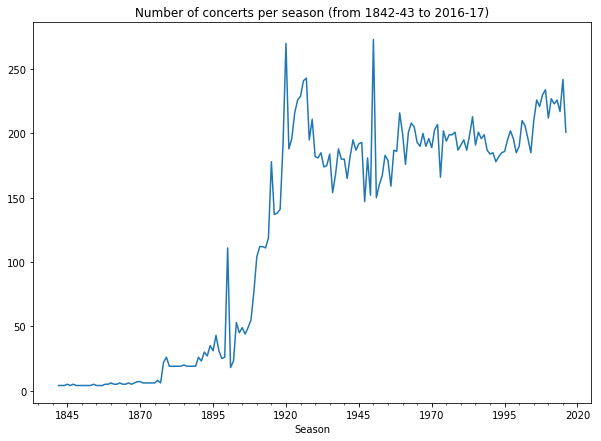

In [23]:
(programs.merge(concerts, on='GUID')
         .groupby('Season')
         .size()
         .plot(legend=False, use_index=True, figsize=(10, 7),
               title='Number of concerts per season (from 1842-43 to 2016-17)'));

Likewise, the number of concerts seems to be trending upwards since about 1995, which could be a sign of growing interest in the genre.

### Join

Now, we want the top-3 composer in terms of total appearances.

Without surprise, we start by importing `works.csv`.

In [24]:
works = pd.read_csv('../data/works.csv')

Alternatively, we can use `df.join()` instead of `df.merge()`. There are, however, differences in the default behaviour: for example`df.join` uses `how='left'` by default.

There is, however, another important difference. Let's set the index of `concerts` to be the `GUID`, following best practices.

In [25]:
works = (works.set_index('GUID')
              .sort_index())

Let's try to perform the merge.

In [26]:
# This will throw an error! Why? Because there's no column GUID on works.
# Uncomment to see the error.
# programs.merge(works, on='GUID')

We can get arround it by using a slightly different syntax, bit by bit:
* We tell Pandas we want to merge the column `GUID` on the left (i.e., `programs`)
* Then, we tell that we want to merge on the index for the dataframe on the right (i.e., `works`). 

In [27]:
(programs.merge(works, left_on='GUID', right_index=True)
         .head(n=3))

,GUID,Orchestra,Season,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670,51207,NaN,"Loeffler, Charles Martin","PAGAN POEM, A",NaN,"Bodanzky, Artur",NaN
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Bodanzky, Artur",NaN
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670,0,NaN,NaN,NaN,NaN,NaN,Intermission


This is the default behaviour when you're using `df.join()`.

In [28]:
(programs.join(works, on='GUID')
         .head(n=3))

# equivalent to
# pd.merge(left, right, left_on='key', right_index=True,
#          how='left')

,GUID,Orchestra,Season,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670.0,51207.0,NaN,"Loeffler, Charles Martin","PAGAN POEM, A",NaN,"Bodanzky, Artur",NaN
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670.0,52446.0,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Bodanzky, Artur",NaN
0,ecd3e77a-b51f-464f-a841-b05ba0738da7,New/National Symphony Orchestra,1919-01-01,13670.0,0.0,NaN,NaN,NaN,NaN,NaN,Intermission


Typically, you would use `df.join()` when you want to do a left join or when you want to join on the index of the dataframe on the right.

Now for our goal: what are the top-3 composers?

In [29]:
(programs.join(works, on='GUID')
         .groupby('ComposerName')
         .size()
         .nlargest(n=3))

ComposerName
Wagner,  Richard               4923
Beethoven,  Ludwig  van        4534
Tchaikovsky,  Pyotr  Ilyich    3700
dtype: int64

Wagner wins!

What about the top-3 works?

In [30]:
(programs.join(works, on='GUID')
         .groupby(['ComposerName', 'WorkTitle'])
         .size()
         .nlargest(n=3))

ComposerName      WorkTitle                        
Wagner,  Richard  MEISTERSINGER, DIE, WWV 96           784
                  TANNHAUSER, WWV 70                   599
                  GOTTERDAMMERUNG [GÖTTERDÄMMERUNG]    592
dtype: int64

Wagner wins three times!